In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import scipy.stats as stats

import arviz as az

import stan

import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import jacobian

In [2]:
import nest_asyncio
nest_asyncio.apply()

# Generate synthetic data

The Lotka-Volterra model is given by the equations:
$$\begin{split}
\frac{du_1}{dt} &= \theta_1 u_1 - \theta_2 u_1 u_2, \\
\frac{du_2}{dt} &= \theta_4 u_1 u_2 - \theta_3 u_2,
\end{split}$$
where $u_1$ and $u_20$ are populations of prey and preditor, respectively, and $\theta_1, \theta_2, \theta_3, \theta_4$ are model parameters. All the quantities are positive.

Define the Lotka-Volterra model:

In [3]:
def lotka_volterra(t, u, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2 = u
    return [
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
    ]

Solve the coupled ODEs:

In [4]:
t_n = 2500  # number of time data points
t_span = [0, 25]  # the time span over which to integrate the system
theta = [0.67, 1.33, 1., 1.]  # parameters of the model
q = 2  # number of state variables
d = len(theta)  # dimension of the parameter space
u_init = [1., 1.]  # initial values

In [5]:
def solve_lotka_volterra(theta):
    sol = solve_ivp(lotka_volterra, t_span, u_init, args=(theta,), dense_output=True)
    t = np.linspace(t_span[0], t_span[1], t_n)
    return t, sol.sol(t).T

In [6]:
t, u = solve_lotka_volterra(theta)

Add Gaussian noise:

In [7]:
rng = np.random.default_rng(12345)

In [8]:
means = [0, 0]
C = np.diag([0.2 ** 2, 0.2 ** 2])

In [9]:
eps = stats.multivariate_normal.rvs(mean=means, cov=C, size=len(u), random_state=rng)
y = u + eps

Plot the resulting values:

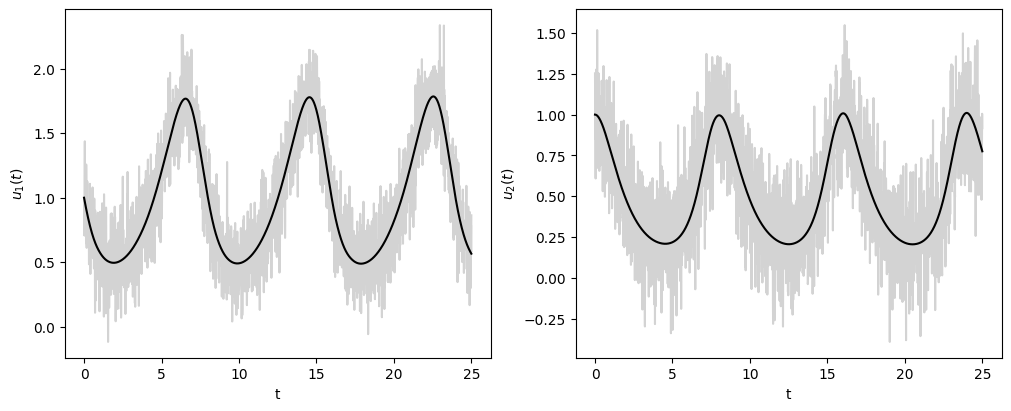

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for i in range(2):
    axs[i].plot(t, y[:, i], color='lightgray');
    axs[i].plot(t, u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

# Sample using a handwritten random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [11]:
def sample_chain(theta_sampler, theta_init, n_samples):
    """Sample a single chain of given length using the starting the values provided"""
    # set the starting values
    theta = np.array(theta_init, copy=True)

    # create an array for the trace
    trace = np.empty((n_samples + 1, d))

    # store the initial values
    trace[0, :] = theta

    # sample variables
    for i in range(n_samples):
        # sample new theta
        theta = theta_sampler(theta)

        # record the value in the trace
        trace[i + 1, :] = theta

    return trace

In [12]:
def to_arviz(chains, var_names):
    """Convert output to arviz format"""
    assert len(chains) > 0
    return az.from_dict({
        var_name: np.stack([chain[:, i] for chain in chains]) for i, var_name in enumerate(var_names)
    })

In [13]:
def metropolis_random_walk_step(log_target_density, proposal_sampler):
    """Perform a Metropolis-Hastings random walk step"""
    def sampler(theta):
        # propose a new value
        theta_proposed = proposal_sampler(theta)

        # decide whether to accept the new value
        log_acceptance_probability = np.minimum(
            0, 
            log_target_density(theta_proposed) - log_target_density(theta)
        )
        u = rng.random()
        if u == 0 or np.log(u) < log_acceptance_probability:
            return theta_proposed
        else:
            return theta

    return sampler

In [14]:
def log_target_density(theta):
    _, u = solve_lotka_volterra(np.exp(theta))
    log_likelihood = np.sum(stats.multivariate_normal.logpdf(y - u, mean=means, cov=C))
    log_prior = np.sum(stats.norm.logpdf(theta))
    return log_likelihood + log_prior

In [15]:
def rw_proposal_sampler(step_size):
    G = step_size * np.identity(d)
    def sampler(theta):
        xi = stats.norm.rvs(size=d, random_state=rng)
        return theta + G @ xi
    return sampler

In [16]:
n_samples = 10_000

In [17]:
# TODO consider selecting step size automatically following Gelman, Roberts, Gilks (1996) Efficient Metropolis Jumping Rules.
step_size = 0.0025

In [18]:
theta_init = np.array([0.55, 1, 0.8, 0.8])

In [19]:
%%time
theta_sampler = metropolis_random_walk_step(log_target_density, rw_proposal_sampler(step_size))
rw_sample = sample_chain(theta_sampler, np.log(theta_init), n_samples)

CPU times: user 2min 14s, sys: 214 ms, total: 2min 14s
Wall time: 2min 17s


Reproduce the first column in Figure S17 from the Supplementary Material:

In [20]:
def plot_trace(samples):
    fig, axs = plt.subplots(1, samples.shape[1], figsize=(15, 3), constrained_layout=True)
    for i in range(d):
        axs[i].plot(samples[:, i]);
        axs[i].set_xscale('log');
        axs[i].set_xlabel('n');
        axs[i].set_ylabel(f'Parameter {i + 1}');

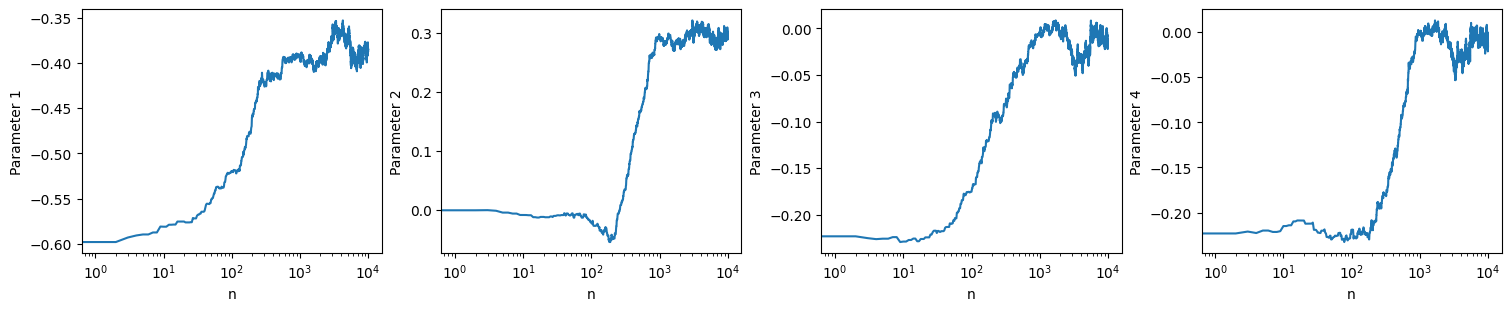

In [21]:
plot_trace(rw_sample)

In [22]:
def acceptance_rate(sample):
    """Fraction of accepted samples"""
    return (np.sum(np.any(sample[1:] != sample[:-1], axis=1)) + 1) / sample.shape[0]

In [23]:
acceptance_rate(rw_sample)

0.2348765123487651

# Sample using Stan

The implementation follows https://mc-stan.org/docs/stan-users-guide/odes.html#estimating-system-parameters-and-initial-state.

In [24]:
stan_model_spec = """
functions {
  vector lotka_volterra(real t, vector u, vector theta) {
    vector[2] dudt;
    dudt[1] = exp(theta[1]) * u[1] - exp(theta[2]) * u[1] * u[2];
    dudt[2] = exp(theta[4]) * u[1] * u[2] - exp(theta[3]) * u[2];
    return dudt;
  }
}
data {
  int<lower=1> T;
  array[T] vector[2] y;
  real t0;
  array[T] real ts;
  vector[2] u0;
  vector<lower=0>[2] sigma;
}
parameters {
  vector[4] theta;
}
model {
  array[T] vector[2] u = ode_rk45(lotka_volterra, u0, t0, ts, theta);
  theta ~ std_normal();
  for (t in 1:T) {
    y[t] ~ normal(u[t], sigma);
  }
}
"""

In [25]:
data = {
    'T': t_n - 1,  # the first time is 0, for which the initial values are fixed
    'y': y[1:, :],
    't0': t_span[0],
    'ts': t[1:],
    'u0': u_init,
    'sigma': np.diag(C),  # TODO pass a matrix and use a multivariate normal in the Stan model
}

In [26]:
%%time
inference_model = stan.build(stan_model_spec, data=data, random_seed=12345)
stan_sample = inference_model.sample(num_chains=1, num_samples=n_samples, init=[{'theta': np.log(theta_init)}])

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_c56rs2u_/model_rmdlkygl.stan', line 22, column 25: The
    variable lotka_volterra may not have been assigned a value before its
    use.
Sampling:   0%
Sampling:   0% (1/11000)
Sampling:   1% (100/11000)
Sampling:   2% (200/11000)
Sampling:   3% (300/11000)
Sampling:   4% (400/11000)
Sampling:   5% (500/11000)
Sampling:   5% (600/11000)
Sampling:   6% (700/11000)
Sampling:   7% (800/11000)
Sampling:   8% (900/11000)
Sampling:   9% (1000/11000)
Sampling:   9% (1001/11000)
Sampling:  10% (1100/11000)
Sampling:  11% (1200/11000)
Sampling:  12% (1300/11000)
Sampling:  13% (1400/11000)
Sampling:  14% (1500/11000)
Sampling:  15% (1600/11000)
Sampling:  15% (1700/11000)
Sampling:  16% (1800/11000)
Sampling:  17% (1900/11000)
Sampling:  18% (2000/11000)
Sampling:  19% (2100/11000)
Sampling:  20% (2200/11000)
Sampling:  21% (2300/11000)
Sampling:  22% (2400/11000)
Sampling:  23% (2500/11000)
Sampling:  24% (2600/110

CPU times: user 25.1 s, sys: 3.11 s, total: 28.2 s
Wall time: 14min 9s


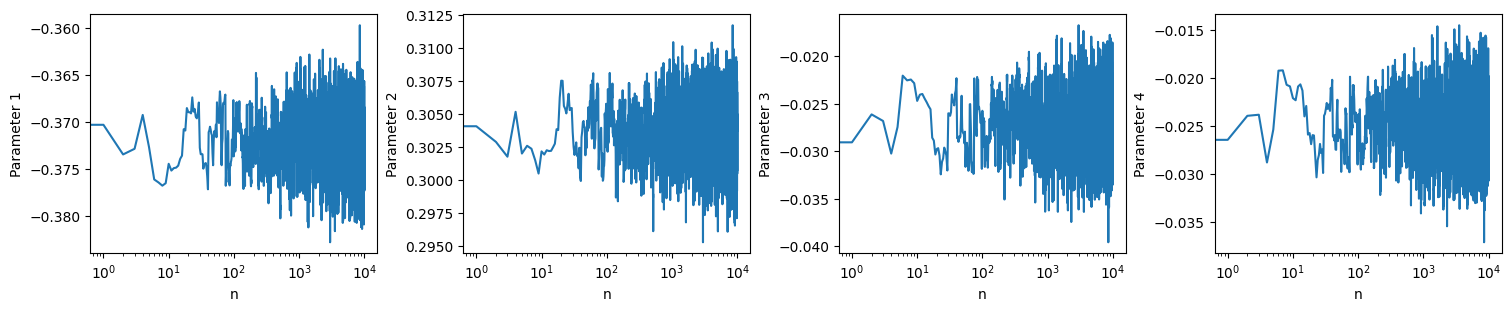

In [27]:
plot_trace(stan_sample['theta'].T)

In [28]:
acceptance_rate(stan_sample['theta'].T)

0.9975

Note that the comparison of the trace with random-walk Metropolis-Hastings is not fair, since Stan performs 1000 warm-up steps which are not included in the trace.

# Sensitivity analysis

## Forward sensitivity equations

Given a system of ODEs of the form:
$$\frac{du_r}{dt} = F_q(t, u_1, \dots, u_q; x),\qquad r=1,\dots,q,$$
the sensitivities can be found by solving forward sensitivity equations (this is equation (35) in the Supplementary Material):
$$\frac{d}{dt}\left(\frac{\partial u_r}{\partial x_s}\right) = \frac{dF_r}{dx_s} + \sum_{l=1}^q \frac{\partial F_r}{\partial u_l} \frac{\partial u_l}{\partial x_s}$$
with initial conditions
$$\frac{\partial u_r}{\partial x_s}(0) = 0.$$

For the Lotka-Volterra model, the forward sensitivity equations are:
$$\begin{split}
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_1}\right) &= u_1 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_1} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_2}\right) &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_2} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_3}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_3} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_4}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_4} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_4}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_1}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_1} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_2}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_2} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_3}\right) &= -u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_3} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_4}\right) &= u_1 u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_4} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_4}. \\
\end{split}$$

Denoting $w_1 = \frac{\partial u_1}{\partial \theta_1}$, $w_2 = \frac{\partial u_1}{\partial \theta_2}$, $w_3 = \frac{\partial u_1}{\partial \theta_3}$, $w_4 = \frac{\partial u_1}{\partial \theta_4}$ and $w_5 = \frac{\partial u_2}{\partial \theta_1}$, $w_6 = \frac{\partial u_2}{\partial \theta_2}$, $w_7 = \frac{\partial u_2}{\partial \theta_3}$, $w_8 = \frac{\partial u_2}{\partial \theta_4}$, we have the following additional equations:
$$\begin{split}
\frac{dw_1}{dt} &= u_1 + (\theta_1 - \theta_2 u_2) w_1 - \theta_2 u_1 w_5, \\
\frac{dw_2}{dt} &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) w_2 - \theta_2 u_1 w_6, \\
\frac{dw_3}{dt} &= (\theta_1 - \theta_2 u_2) w_3 - \theta_2 u_1 w_7, \\
\frac{dw_4}{dt} &= (\theta_1 - \theta_2 u_2) w_4 - \theta_2 u_1 w_8, \\
\frac{dw_5}{dt} &= \theta_4 u_2 w_1 + (\theta_4 u_1 - \theta_3) w_5, \\
\frac{dw_6}{dt} &= \theta_4 u_2 w_2 + (\theta_4 u_1 - \theta_3) w_6, \\
\frac{dw_7}{dt} &= -u_2 + \theta_4 u_2 w_3 + (\theta_4 u_1 - \theta_3) w_7, \\
\frac{dw_8}{dt} &= u_1 u_2 + \theta_4 u_2 w_4 + (\theta_4 u_1 - \theta_3) w_8. \\
\end{split}$$

In [29]:
def lotka_volterra_sensitivity(t, uw, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2, w1, w2, w3, w4, w5, w6, w7, w8 = uw
    return [
        # model equations
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
        # sensitivities
        u1 + (theta1 - theta2 * u2) * w1 - theta2 * u1 * w5,
        -u1 * u2 + (theta1 - theta2 * u2) * w2 - theta2 * u1 * w6,
        (theta1 - theta2 * u2) * w3 - theta2 * u1 * w7,
        (theta1 - theta2 * u2) * w4 - theta2 * u1 * w8,
        theta4 * u2 * w1 + (theta4 * u1 - theta3) * w5,
        theta4 * u2 * w2 + (theta4 * u1 - theta3) * w6,
        -u2 + theta4 * u2 * w3 + (theta4 * u1 - theta3) * w7,
        u1 * u2 + theta4 * u2 * w4 + (theta4 * u1 - theta3) * w8,
    ]

In [30]:
uw_init = np.concatenate([np.array(u_init), np.zeros(d * q)])

In [31]:
%%time
sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
sensitivity_forward = sol.sol(t).T

CPU times: user 12.7 ms, sys: 3.9 ms, total: 16.6 ms
Wall time: 16 ms


Plot the solution again:

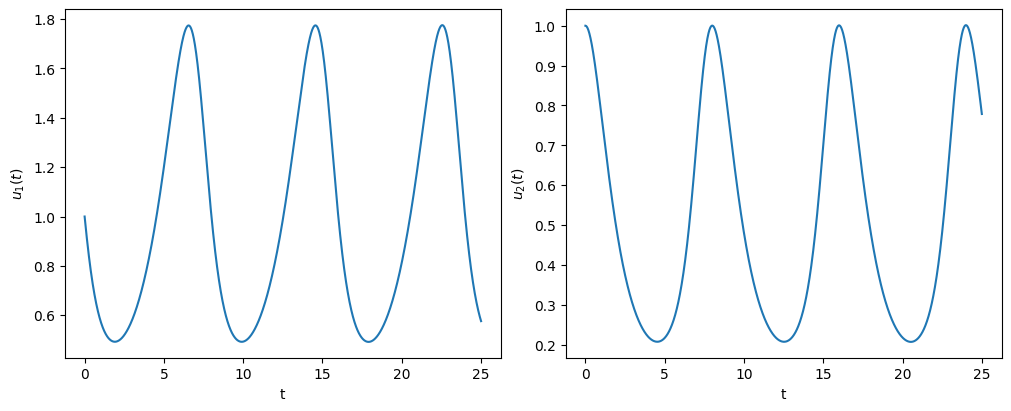

In [32]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
for i in range(q):
    axs[i].plot(t, sensitivity_forward[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Plot the sensitivities:

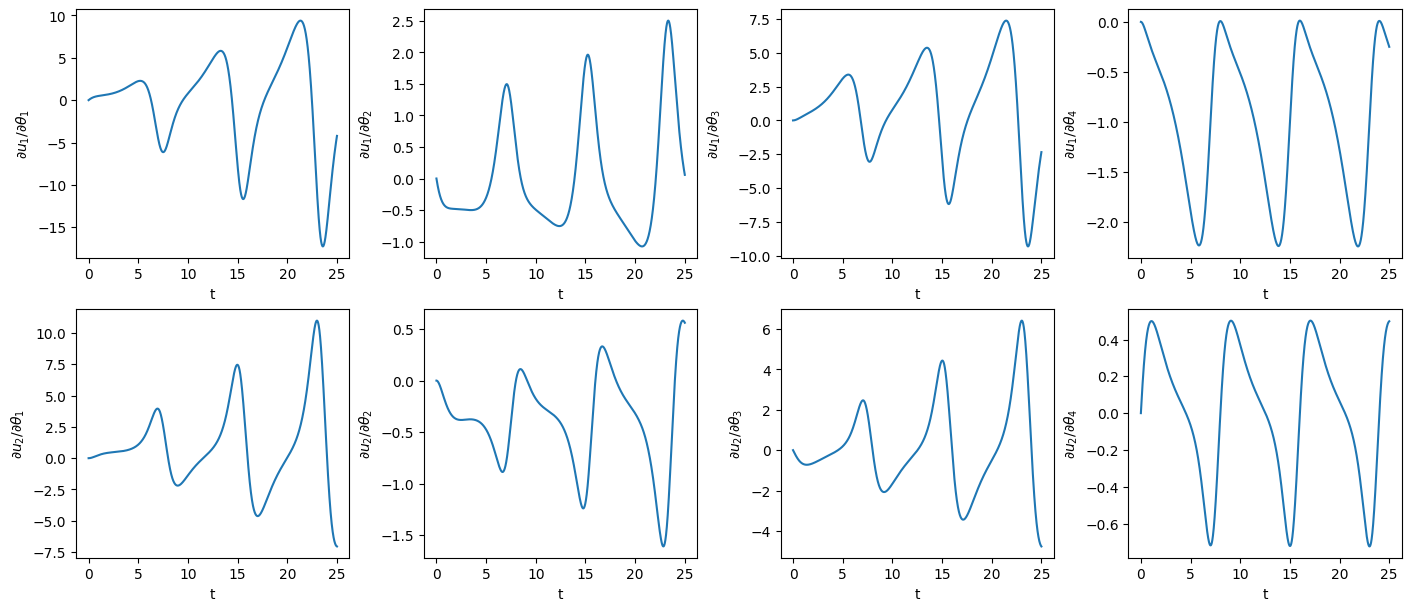

In [33]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
for i in range(q):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, q + i * d + j]);
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');

## Numerical Jacobian calculation

Redefine the function as ``jax.experimental.ode.odeint`` passes the state variable in the first argument and time in the second argument:

In [34]:
def lotka_volterra2(u, t, theta):
    return [
        theta[0] * u[0] - theta[1] * u[0] * u[1],
        theta[3] * u[0] * u[1] - theta[2] * u[1],
    ]

In [35]:
def solve_lotka_volterra2(theta):
    return odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))

In [36]:
sol2 = solve_lotka_volterra2(theta)

Plot the solution first:

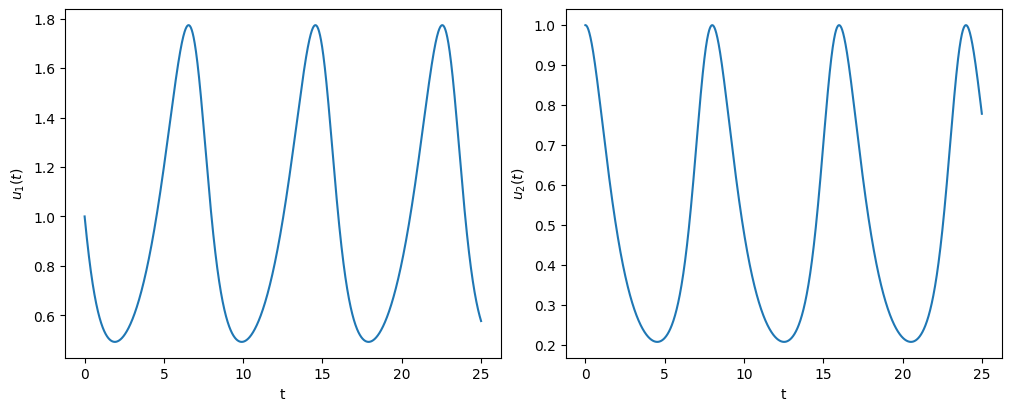

In [37]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
for i in range(q):
    axs[i].plot(t, sol2[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Calculate the sensitivities:

In [38]:
%%time
sensitivity_jax = jacobian(solve_lotka_volterra2)(theta)

CPU times: user 31.2 s, sys: 443 ms, total: 31.6 s
Wall time: 31.1 s


We confirm that the numerical method agrees with the results from forward sensitivity equations:

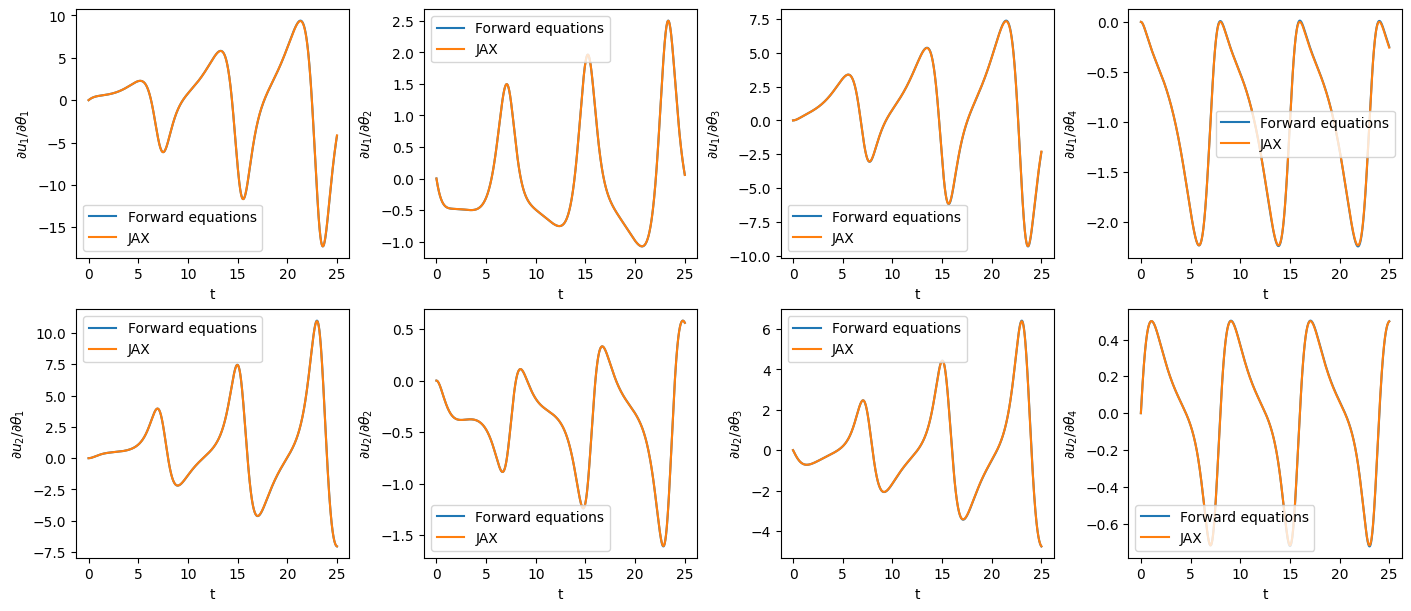

In [39]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
for i in range(2):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, 2 + i * d + j], label='Forward equations');
        axs[i][j].plot(t, sensitivity_jax[j][:, i], label='JAX');
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');
        axs[i][j].legend();

## Calculating the gradient of the log-posterior

The Stein Thinning methog requires the gradient of the log-posterior $\nabla \log p$ as input. Below we follow section S3 of the Supplementary Material to derive it.

Since $p(x) \propto \mathcal{L}(x) \pi(x)$, we have 
$$\nabla \log p(x) = \nabla \log \mathcal{L}(x) + \nabla \log \pi(x).$$
Assuming independent errors in observations yields
$$\mathcal{L}(x) = \prod_{i=1}^N \phi_i(u(t_i)),$$
and thus 
$$
\frac{\partial}{\partial x_s} \log \mathcal{L}(x) 
= \sum_{i=1}^N \frac{\partial}{\partial x_s} \log \phi_i(u(t_i))
= \sum_{i=1}^N \sum_{r=1}^q \frac{\partial}{\partial u_r} (\log \phi_i) \frac{\partial u_r}{\partial x_s},
$$
which can be written in matrix notation as
$$(\nabla \log \mathcal{L})(x) = \sum_{i=1}^N \left(\frac{\partial u}{\partial x}\right)^T (t_i) (\nabla \log \phi_i)(u(t_i)),$$
where
$$\left(\frac{\partial u}{\partial x}\right)_{r,s} = \frac{\partial u_r}{\partial x_s}$$
is the Jacobian matrix of sensitivities, as obtained earlier.

Note that this does not match the expression provided on page 16 of the Supplementary Material:
$$(\nabla \log \mathcal{L})(x) = -\sum_{i=1}^N \frac{\partial u}{\partial x}(t_i) (\nabla \log \phi_i)(u(t_i)),$$
where the Jacobian is not transposed and there is a minus sign in front of the expression.

Assuming multivariate normal distribution for the errors,
$$\phi_i(u(t_i)) \propto \exp\left( -\frac{1}{2} (y_i - u(t_i))^T C^{-1} (y_i - u(t_i)) \right),$$
so
$$(\nabla \log \phi_i)(u(t_i)) = C^{-1}(y_i - u(t_i)).$$

We assume independent standard normal priors for all parameters, therefore
$$\pi(x) = \prod_{i=1}^d \pi_i(x_i) \propto \exp\left(-\frac{1}{2}\sum_{i=1}^d x_i^2\right)$$
and
$$\nabla \log \pi(x) = -x.$$

We calculate the gradient of the log-likelihood from the Jacobian obtained above and the equations:

In [40]:
# reshape the Jacobian so it can be multiplied by the gradient of log phi
J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
J.shape

(2500, 4, 2)

In [41]:
# calculate the gradient of log phi and reshape it
grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
grad_log_phi.shape

(2500, 2, 1)

In [42]:
grad_log_lik = np.sum(np.squeeze(J @ grad_log_phi), axis=0)
grad_log_lik

array([2356.59024031, -295.14399231, 1279.60868829,  -98.99938362])

Now put the calculation into a function so we can use it later:

In [43]:
def grad_log_likelihood(theta):
    """Solve the system of ODEs and calculate the log-likelihood"""
    sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
    sensitivity_forward = sol.sol(t).T
    J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
    grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
    return np.sum(np.squeeze(J @ grad_log_phi), axis=0)

In [44]:
%%time
grad_log_likelihood(theta)

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.7 ms


array([2356.59024031, -295.14399231, 1279.60868829,  -98.99938362])

We check the numbers against the numerical gradient:

In [45]:
def grad_log_likelihood_jax(theta):
    import jax.scipy.stats as jstats
    def log_likelihood(theta):
        sol = odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))
        return jnp.sum(jstats.multivariate_normal.logpdf(jnp.array(y) - sol, mean=jnp.array(means), cov=jnp.array(C)))
    return jacobian(log_likelihood)(theta)

In [46]:
%%time
grad_log_likelihood_jax(theta)

CPU times: user 2.43 s, sys: 99.1 ms, total: 2.52 s
Wall time: 2.43 s


[Array(2315.5823, dtype=float32, weak_type=True),
 Array(-276.83807, dtype=float32, weak_type=True),
 Array(1271.811, dtype=float32, weak_type=True),
 Array(-105.94492, dtype=float32, weak_type=True)]

We use the gradient calculation based on solving forward sensitivity equations in what follows.

In [47]:
def grad_log_posterior(theta):
    return grad_log_likelihood(theta) - theta

In [48]:
grad_log_posterior(theta)

array([2355.92024031, -296.47399231, 1278.60868829,  -99.99938362])

## Sequential calculation of gradients

We can save time by calculating the gradients only for unique samples:

In [49]:
unique_samples = np.unique(np.exp(rw_sample), axis=0)
unique_samples.shape

(2349, 4)

In [50]:
%%time
grad = np.apply_along_axis(grad_log_posterior, 1, unique_samples)

CPU times: user 29.6 s, sys: 16.6 s, total: 46.3 s
Wall time: 23.5 s


## Parallel calculation of gradients

We note that calculating gradients after a MCMC run is what is called "embarrassingly parallelisable" and the time required for this step can be driven down given sufficient computational resources. This is in contrast to the MCMC run itself, which is inherently sequential.

We demonstrate using the popular package ``Dask`` to parallelise this computation across the cores of a CPU on a single machine.

In [51]:
import dask.array as da
from dask.distributed import Client, progress

In [60]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43713 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43713/status,
Dashboard: http://127.0.0.1:43713/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41669,Workers: 4
Dashboard: http://127.0.0.1:43713/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:44991,Total threads: 4
Dashboard: http://127.0.0.1:38895/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:37459,


We develop a simple helper function to perform a given calculation across row chunks:

In [61]:
def apply_along_axis_parallel(func1d, axis, arr, chunk_size):
    """Apply function along the given axis and parallelise in chunks"""
    assert axis in (0, 1)

    def func(chunk):
        return np.apply_along_axis(func1d, axis, chunk)

    # select chunks and submit them for parallel processing
    n_chunks = (arr.shape[1 - axis] - 1) // chunk_size + 1
    results = []
    for i in range(n_chunks):
        index_slice = slice(i * chunk_size, (i + 1) * chunk_size)
        if axis == 1:
            chunk = arr[index_slice, :]
        else:
            chunk = arr[:, index_slice]

        result = client.submit(func, chunk)
        results.append(result)

    # await the results
    results = client.gather(results)
    
    # reshape the results
    for i, result in enumerate(results):
        if len(result.shape) == 1:
            if axis == 1:
                results[i] = result.reshape(-1, 1)
            else:
                results[i] = result.reshape(1, -1)
    
    return np.concatenate(results, axis=1 - axis)

In [64]:
%%time
grad_parallel = apply_along_axis_parallel(grad_log_posterior, 1, unique_samples, 200)

CPU times: user 1.49 s, sys: 135 ms, total: 1.62 s
Wall time: 8.9 s


Confirm the values are identical to the sequential run:

In [68]:
np.max(np.abs(grad_parallel - grad))

0.0